# Simulations for NJ4 single-strain model

In [1]:
from cobra.io import read_sbml_model

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")

### Additional constraints:
TODO - place someplace more re-usible where a new model is written? Put here for the time-being.

Note: a bug in cobrapy means that bounds are overwritten when calling an imported function unless the model is written to file? I think? Be careful about calling functions from scripts in util if they chnage bounds without writing the model to file...

In [2]:
nj4_acido = nj4.copy()
nj4_solvento = nj4.copy()

In [3]:
# make the reactions in the ABE pathway irreversible

reactions = ["POR_syn",
            "ACACT1r",
            "HACD1",
            "ECOAH1",
            "ACOAD1fr",
            "ACOAD1",
            "BTCOARx",
            "PBUTT",
            "ADCi",
            "PTAr"]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD"]

for rx in reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 1000)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (-1000, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (-1000, 0)

In [4]:
# knock out reactions for xylan uptake

xylan_rx = ["XYLANabc", "GLCURS1"]

for rx in xylan_rx:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 0)

In [5]:
# flux coupling for acetate and butyrate yields with xylose - for acidogenic phase

from utils.flux_coupling import add_ratio_constraint_cobra

xylose_transport_KO = ["XYLtex", "XYLabc", "XYLt2"]

for rx in xylose_transport_KO:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)

add_ratio_constraint_cobra(nj4_acido, "BUTt" , "XYLt",  0.166, r_num_reverse=False, r_den_reverse=True)
add_ratio_constraint_cobra(nj4_acido, "ACtr" , "XYLt",  0.162, r_num_reverse=False, r_den_reverse=True)

Metabolite identifier,ratio_ACtr_XYLt
Name,
Memory address,0x105d77070
Formula,None
Compartment,pseudo
In 2 reaction(s),"XYLt, ACtr"


In [ ]:
# constraints for the solventogenic phase

# TODO: add constraints for the solventogenic phase

# coupled uptake of butyrate and acetate?
# forced acetone production?

## Static modelling

Goal: replicate the distinct phases acidogenesis and solventogenesis

In [62]:
from utils import static_sim

medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

production_reactions = [
    'EX_btoh_e', # butanol exhange
    'EX_etoh_e', # ethanol exchange
    'EX_ac_e', # acetate exchange
    'EX_but_e', # butyrate exchange
    'EX_acetone_e', # acetone exchange
]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [5]:
from cobra.flux_analysis import pfba

with nj4:
    nj4.medium = medium
    
    summary = nj4.summary()
    solution = nj4.optimize()
    pfba_solution = pfba(nj4)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [6]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,0.1,6,1.05%
asp__L_e,EX_asp__L_e,0.1,4,0.70%
ca2_e,EX_ca2_e,0.001847,0,0.00%
cl_e,EX_cl_e,0.001847,0,0.00%
cobalt2_e,EX_cobalt2_e,3.549E-05,0,0.00%
cu2_e,EX_cu2_e,0.0002516,0,0.00%
cys__L_e,EX_cys__L_e,0.03278,3,0.17%
fe2_e,EX_fe2_e,0.002383,0,0.00%
fe3_e,EX_fe3_e,0.002771,0,0.00%
fol_e,EX_fol_e,0.0002374,19,0.01%


- the models main carbon source is xylose, but is also taking up several amino-acids
- butyrate and acetate are being secreted, which is as expected during the solventogenic phase

In [8]:
import escher
from escher import Builder

builder = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)

In [9]:
builder.reaction_data = pfba_solution.fluxes

In [10]:
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [13]:
static_sim.read_production_rates(pfba_solution)

Production fluxes:
EX_but_e         0.179085
EX_ac_e         16.272715
EX_etoh_e        0.000000
EX_btoh_e       -0.000000
EX_acetone_e     0.000000
Name: fluxes, dtype: float64


- model behaving as we would expect in solventogenic phase
- however, there are several optimal solutions here

In [14]:
static_sim.get_productions(nj4, medium=medium)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,pFBA sol,minimum,maximum
EX_ac_e,16.272715,6.656005,1.659098e+01
EX_but_e,0.179085,0.000000,3.384656e+00
EX_etoh_e,0.000000,0.000000,-2.327027e-13
EX_btoh_e,-0.000000,0.000000,-1.709743e-13
EX_acetone_e,0.000000,0.000000,-2.841061e-13


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

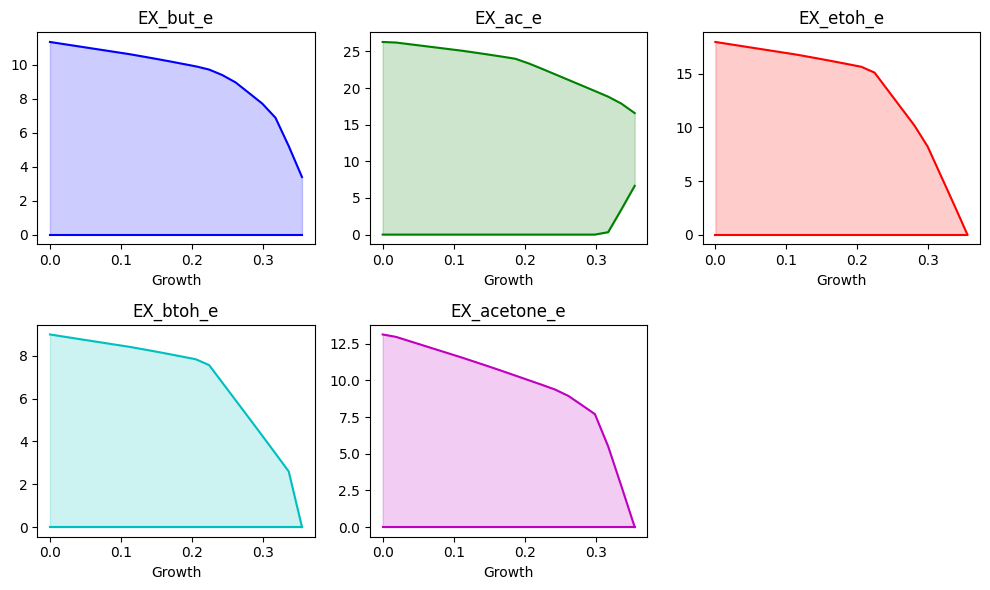

In [15]:
from utils import static_sim

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e", "EX_acetone_e"]

static_sim.plot_flux_envelopes(nj4, medium=medium, reactions=prod_reactions)

- the model displays clear preference for acetate production, and this is the only product that is flux-coupled
- butyrate is not flux-couplued, but the solution allows production at max growth

Studying the flux ranges of each reaction:

In [16]:
ABE_REACTIONS = ["POR_syn", "ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", "ADCi", 
                 "PTAr", "ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD", "ACtr", "FNRR", "ALCD2x",
                 "ETOHtrpp", "ETOHtex", "BTOHt", "ACEt", "BUTt"]

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


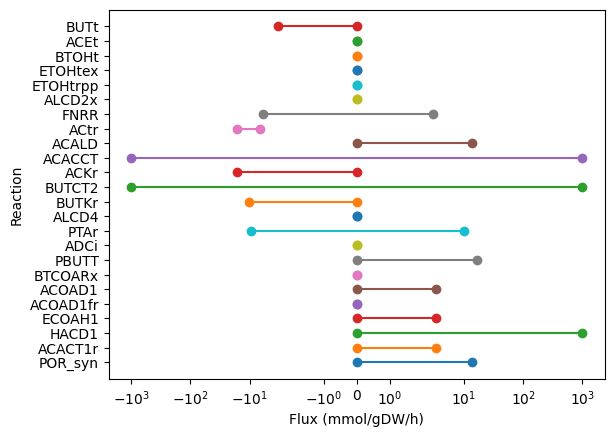

In [17]:
static_sim.plot_flux_ranges(model=nj4, medium=medium, reactions=ABE_REACTIONS)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


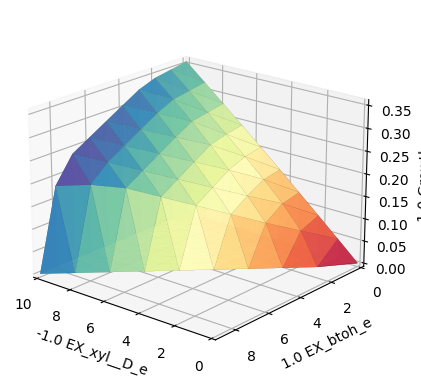

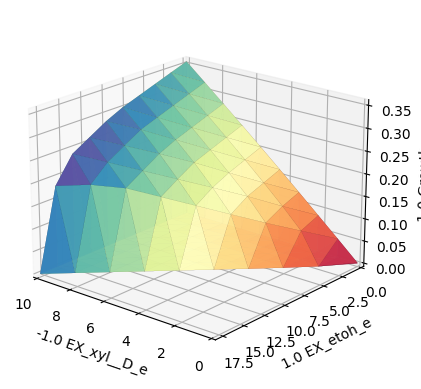

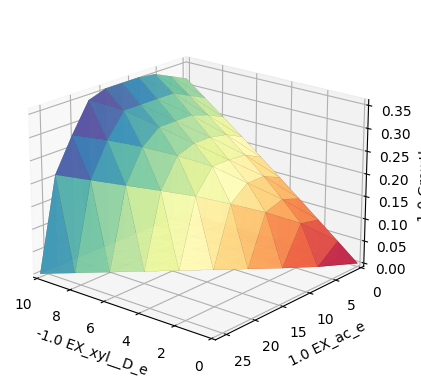

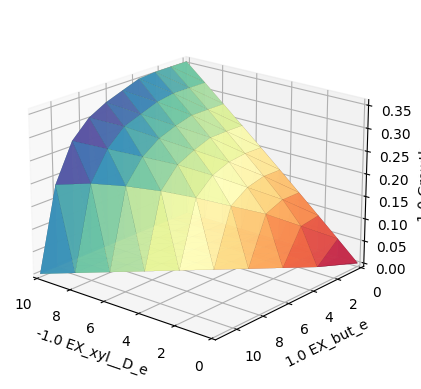

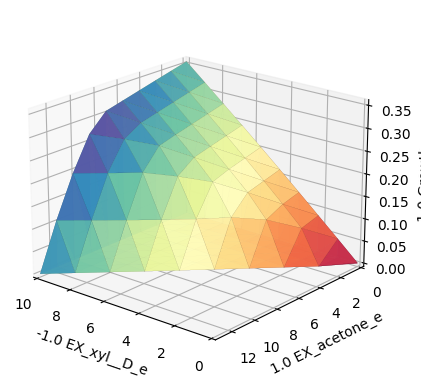

In [18]:
import straindesign as sd
import matplotlib.pyplot as plt

with nj4:
    nj4.medium = medium

    for rx in production_reactions:
        _,_,plot = sd.plot_flux_space(nj4,('-EX_xyl__D_e',rx, 'Growth'),points=10, show=False);
        plot._axes.view_init(elev=20, azim=130)
        plt.show()

## More detailed acidogenic / solventogenic modelling

At standard growth maximisation the model should prefer butyrate / acetate production - since this is the strategy that Clostridium bacteria chose durting exponential growth phase.

Modelling og solventogenic phase as detailed in methods from: [Genome-scale reconstruction and in silico analysis of the Clostridium acetobutylicum ATCC 824 metabolic network](https://doi.org/10.1007/s00253-008-1654-4) (minimal metabolic adjustment from acidogenesis) and [Stoichiometric modeling of Clostridium acetobutylicum fermentations with non-linear constraints](https://doi.org/10.1016/S0168-1656(99)00022-X) (non-liner constraint on acetate and butyrate re-utilisation).

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


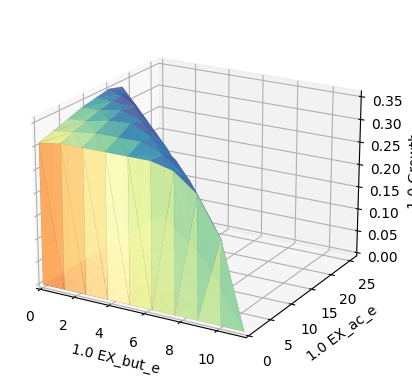

In [23]:
import straindesign as sd
import matplotlib.pyplot as plt
from utils import static_sim

with nj4:
    nj4.medium = medium

    _,_,plot = sd.plot_flux_space(nj4,('EX_but_e','EX_ac_e', 'Growth'),points=10, show=False);
    plot._axes.view_init(elev=20, azim=300)
    plt.show()

We see that the growth is maximised most when there is production of both acetate and butyrate. 

In [24]:
from utils import static_sim

acidogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10,}, fill_value=0.1)

with nj4:
    nj4.medium = acidogenic_medium
    acidogenic_summary = nj4.summary()
    acidogenic_sol = nj4.optimize()

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


### solventogenic phase

impose constraints on butyrate and acetate uptake like in the article, then solve a MOMA problem from the previous solution like done in the iJL432 paper

use data from CBP paper to find appropriate ac / but constraint?

In [25]:
from utils.flux_coupling import add_ratio_constraint_cobra

add_ratio_constraint_cobra(nj4, "EX_but_e" , "EX_ac_e", 0.315)

Metabolite identifier,ratio_EX_but_e_EX_ac_e
Name,
Memory address,0x124ceead0
Formula,None
Compartment,pseudo
In 2 reaction(s),"EX_ac_e, EX_but_e"


In [30]:
from cobra.flux_analysis import moma

solventogenic_medium = static_sim.get_specific_medium(nj4, {"EX_xyl__D_e": 10, "EX_nh4_e": 10, "EX_but_e": 10, "EX_ac_e": 10, "EX_h_e": 10})

with nj4:
    nj4.medium = solventogenic_medium

    nj4.reactions.EX_but_e.bounds = (-10, 0)
    nj4.reactions.EX_ac_e.bounds = (-10, 0)
    
    # solve a moma problem!
    solventogenic_sol = moma(nj4, solution=acidogenic_sol)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [28]:
import escher
from escher import Builder

builder_acido = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)
builder_acido.reaction_data = acidogenic_sol.fluxes
builder_acido

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

In [32]:
import escher
from escher import Builder

builder_solvento = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)
builder_solvento.reaction_data = solventogenic_sol.fluxes
builder_solvento

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR160tipp': 0.0, '12DGR161tip…

## Dynamic modelling

In [6]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

nj4_med = media_db[media_db["medium"] == "nj4_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in nj4_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}
added_metabilotes["xyl__D_e"] = 20 # 20 mmol corresponds to 60 g/L xylose

In [7]:
km = {"EX_xyl__D_e": 1}
vmax = {"EX_xyl__D_e": 6}

In [147]:
from utils.comets_functions import single_strain

sim = single_strain(model=nj4_acido, medium=added_metabilotes, sim_time=96, km_dict=km, vmax_dict=vmax)


Running COMETS simulation ...
Done!


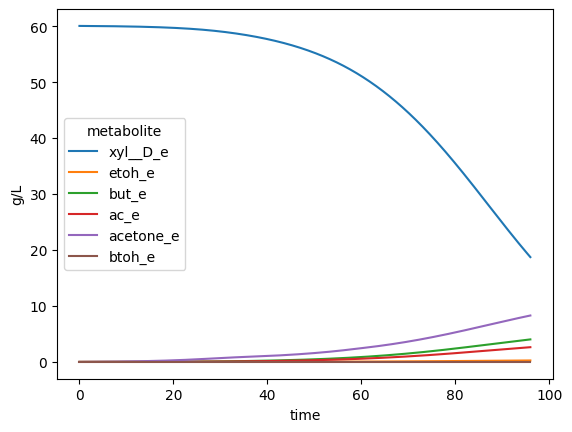

In [148]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "acetone_e"]

plot_metabolites(sim, metabolites)

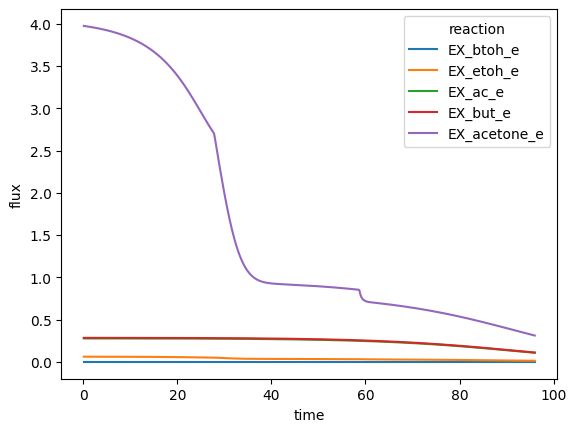

In [149]:
prod_reactions = ['EX_btoh_e', 'EX_etoh_e', 'EX_ac_e', 'EX_but_e', 'EX_acetone_e',]

plot_reaction_flux(sim, prod_reactions, "NJ4")

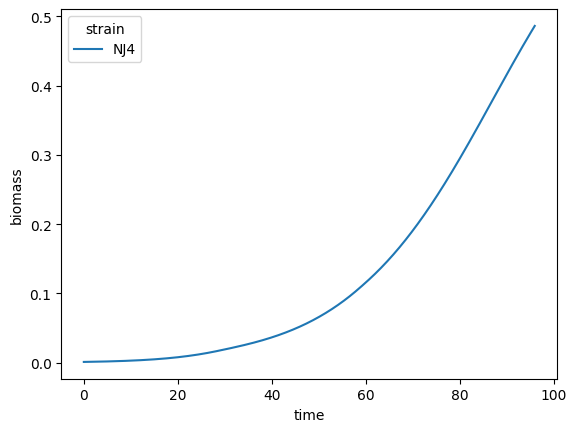

In [150]:
plot_biomass(sim)

In [8]:
from utils.comets_functions import two_phase_sim

acido_sim, solvento_sim = two_phase_sim(nj4_acido, nj4_solvento, medium=added_metabilotes, km_dict=km, vmax_dict=vmax)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [29]:
import numpy as np

def collapse_sequential_sim(sim_1, sim_2, mult_species=True):
    """Helper function to combine the results from 2 sequential simulation objects generated by sequential_com() into dataframes for analysis.

    Args:
        sim_1 (c.sim): first simulation object
        sim_2 (c.sim): second simulation object

    Returns:
        df: dataframe of biomass, metabolite and a dictionary of flux time-series data for each strain.
    """

    # biomass
    bm_1 = sim_1.total_biomass.copy()
    bm_2 = sim_2.total_biomass.copy()

    cycle_diff = bm_1["cycle"].iloc[bm_1.shape[0]-1] + 1

    bm_2["cycle"] = bm_2["cycle"] + cycle_diff
    bm = pd.concat([bm_1, bm_2]).fillna(value=0)

    # metabolies
    met_1 = sim_1.get_metabolite_time_series()
    met_2 = sim_2.get_metabolite_time_series()

    met_2["cycle"] = met_2["cycle"] + cycle_diff
    met = pd.concat([met_1, met_2]).fillna(value=0)

    # fluxes
    if mult_species:
        # M5 fluxes
        flux_1_a = sim_1.fluxes_by_species["M5"].copy()
        flux_2_a = sim_2.fluxes_by_species["M5"].copy()
        flux_2_a["cycle"] = flux_2_a["cycle"] + cycle_diff
        flux_1 = pd.concat([flux_1_a, flux_2_a]).fillna(value=0)

        #NJ4 fluxes
        flux_2 = sim_2.fluxes_by_species["NJ4"].copy()
        flux_2["cycle"] = flux_2["cycle"] + cycle_diff
        # adding in 0s for the cycles before NJ4 is added
        zeros_df = pd.DataFrame(0, index=range(cycle_diff), columns=flux_2.columns)
        zeros_df["cycle"] = np.arange(1,cycle_diff+1)
        flux_2 = pd.concat([zeros_df, flux_2], ignore_index=True)

        fluxes = {"M5": flux_1, "NJ4": flux_2}

    else:
        species_id = list(acido_sim.fluxes_by_species.keys())[0]
        flux_1 = sim_1.fluxes_by_species[species_id].copy()
        flux_2 = sim_2.fluxes_by_species[species_id].copy()
        flux_2["cycle"] = flux_2["cycle"] + cycle_diff
        flux_1 = pd.concat([flux_1, flux_2]).fillna(value=0)
        fluxes = {species_id: flux_1}


    return bm, met, fluxes

In [37]:
bm, met, fluxes = collapse_sequential_sim(acido_sim, solvento_sim, mult_species=False)

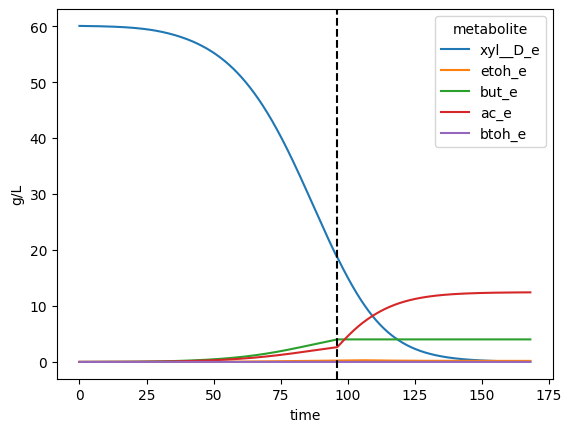

In [31]:
from utils import comets_functions as cf

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e"]#, "xylan4_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=96)

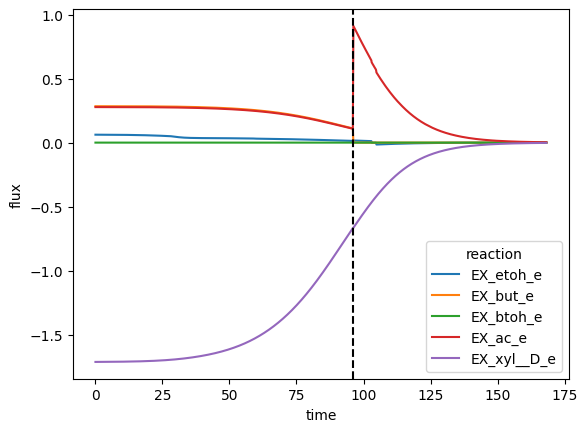

In [32]:
import matplotlib.pyplot as plt

production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=96)

In [33]:
import escher
from escher import Builder

animation = Builder(map_json='escher_maps/ABE_pretty.json', model=nj4, height=600)

In [39]:
from time import sleep
from tqdm.notebook import tqdm

#animate_fluxes = sim.fluxes_by_species["NJ4"].drop(columns=["x", "y"])
animate_fluxes = fluxes["NJ4"].drop(columns=["x", "y"])

melted_fluxes = animate_fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = animate_fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    animation.reaction_data = flux_series
    sleep(0.1)

  0%|          | 0/1680 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
animation

Builder(height=600)